## Критерий согласия Пирсона (критерий согласия хи-квадрат)

Также называется критерием **согласия $\chi^{2}$**.

Это **непараметрический** метод, позволяющий оценить значимость различий между фактическим (выявленным в результате исследования) количеством исходов или качественных характеристик выборки, попадающих в каждую категорию, и теоретическим количеством, которое можно ожидать в изучаемых группах при справедливости нулевой гипотезы.

Наиболее употребляемый критерий для проверки гипотезы о принадлежности наблюдаемой выборки $x_1, x_2, \ldots, x_n$ объемом $n$ некоторому теоретическому закону распределения $Z$.

$$
\begin{equation*}
\begin{cases}
H_{0}: X \sim Z\\
H_{1}: X \nsim Z
\end{cases}
\end{equation*}
$$

К примеру, у нас есть выборка размера $n = 1000$. И мы предполагаем, что данная выборка принадлежит рапределению $N(-2, 5)$.

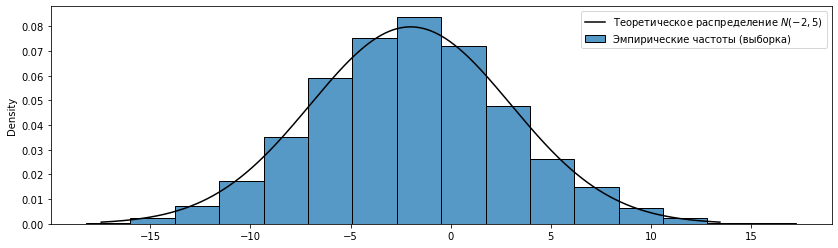

In [1]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Union

import warnings
warnings.filterwarnings("ignore")


n = 1000
loc, scale = -2, 5

# генерируем псевдослучайную выборку для проведения эксперимента
sample = stats.norm.rvs(loc=-2, scale=5, size=n, random_state=42)

# функция плотности теоретического распределения, принадлежность нашей выборки к которому мы хотим проверить
x = np.linspace(
    stats.norm.ppf(0.001, loc=loc, scale=scale),
    stats.norm.ppf(0.999, loc=loc, scale=scale), 1000
)
y = stats.norm.pdf(x, loc=loc, scale=scale)

fig, ax = plt.subplots(figsize=(14, 4))
sns.histplot(sample, stat="density", bins=16, ax=ax)
sns.lineplot(x=x, y=y, ax=ax, c="black")
ax.legend([
    "Теоретическое распределение $N(-2, 5)$", 
    "Эмпирические частоты (выборка)"], loc=1)
fig.show()

Как мы видим, между **эмпирическими частотами** и **теоретическим распределением** существует разница. И возникает вопрос, **объясняются ли эти расхождения только случайными обстоятельствами, или же они являются следствием того, теоретическое распределение плохо описывает природу наших данных?**

Карл Пирсон разработал математический инструмент проверки нулевой гипотезы $H_0$, что **теоретическая кривая корректно описывает экспериментальные данные гистограммы** - критерий согласия хи-квадрат (или критерий соласия Пирсона). Основан на оценке степени близости гистограммы относительных частот выборки и теоретической плотности распределения.

Под относительной частотой понимается величина:

$$
\overline{p}_i = \frac{m_i}{n}
$$

Причем 

$$
\sum_{i=1}^{k} \overline{p}_{i} = 1
$$
$$
\sum_{i=1}^{k} m_{i} = n
$$

где

- $i = 1, 2, \ldots, k$ - индекс интервала (бина гистограммы)
- $k$ - количество интервалов (бинов гистограммы)
- $m_{i}$ - количество экспериментов для одного интервала
- $n$ - общее количество экспериментов

In [2]:
# определяем границы отрезка для разбиения на интервалы
a = min(stats.norm.ppf(0.01, loc=loc, scale=scale), np.min(sample))
b = max(stats.norm.ppf(0.99, loc=loc, scale=scale), np.max(sample))

# округлим нижнюю границу и верхнюю до целых в меньшую и большую стороны соответственно
a, b = np.floor(a), np.ceil(b)

# а также количестов бинов, на которое мы этот отрезок разобьем
n_bins = 16

print(f"Количество бинов:\t{n_bins}")
print("Отрезок, который будем разбивать на равные бины: [{}, {})".format(a, b))

Количество бинов:	16
Отрезок, который будем разбивать на равные бины: [-19.0, 18.0)


Разобьем отрезок $\left [ -19, 18 \right )$ на $k = 16$ равных отрезков $[a_0 = -19, a_1), [a_1, a_2), \ldots , [a_{k-1}, a_k = 18)$. Сформируем таблицу с частотами и относительными частотами (колонки `m` и `p_` соответственно) наших данных.

In [3]:
df = pd.DataFrame(data={"values": sample})
df["intervals"] = pd.cut(df["values"], bins=np.linspace(a, b, n_bins + 1, endpoint=True),
                         right=False)
frequences = df.groupby(by="intervals", sort=True).count()
frequences = frequences.reset_index(drop=False)
frequences = frequences.rename(columns={"values": "m"})
frequences["p_"] = frequences["m"] / n

Проверим, что $\sum_{i=1}^{k} \overline{p}_i = 1$

In [4]:
frequences["p_"].sum()

1.0

Проверим, что $\sum_{i=1}^{k} m_{i} = n$

In [5]:
frequences["m"].sum() == n

True

Отлично, теперь необходимо посчитать теоретические частоты (вероятности) нашего распределения в указанных интервалах (вероятность того, что СВ попадет в данный интервал).

In [6]:
def calculate_proba(interval: pd.Interval, loc: Union[int, float], scale: Union[int, float]) -> float:
    left, right = interval.left, interval.right
    return stats.norm.cdf(right, loc=loc, scale=scale) - stats.norm.cdf(left, loc=loc, scale=scale)


frequences["p"] = frequences["intervals"].apply(calculate_proba, loc=loc, scale=scale)
frequences["p"] = frequences["p"].astype("float")

Выведем результаты

In [7]:
frequences

,intervals,m,p_,p
0,"[-19.0, -16.688)",1,0.001,0.001317
1,"[-16.688, -14.375)",3,0.003,0.005008
2,"[-14.375, -12.062)",13,0.013,0.015427
3,"[-12.062, -9.75)",32,0.032,0.038482
4,"[-9.75, -7.438)",76,0.076,0.077815
5,"[-7.438, -5.125)",130,0.130,0.127600
6,"[-5.125, -2.812)",172,0.172,0.169510
7,"[-2.812, -0.5)",194,0.194,0.182416
8,"[-0.5, 1.812)",168,0.168,0.159178
9,"[1.812, 4.125)",102,0.102,0.112623


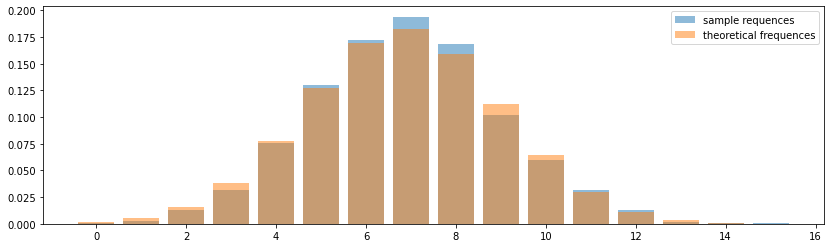

In [8]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.bar(x=frequences.index, height=frequences["p_"], alpha=0.5, label="sample requences")
ax.bar(x=frequences.index, height=frequences["p"], alpha=0.5, label="theoretical frequences")
ax.legend()
fig.show()

Рассогласование выборочных частот с теоретическими можно рассматривать как $\sum_{i=1}^{k} \left ( \overline{p}_{i} - p_{i} \right )^2$ (квадрат, чтобы избежать отприцательных значений). И чем меньше эта величина, тем меньше рассогласование. 

Пирсон записал критерий согласованности в следующем виде:

$$
U = \sum_{i=1}^{k} c_{i} \left ( \overline{p_{i}} - p_{i} \right )^2
$$

где 
$$
c_{i} = \frac{n}{p_{i}}, i = 1, 2, \ldots, k
$$
вес каждого разряда

И было показано, что при достаточно больших $n$ данная величина $U$ стремится к распределнию $\chi^2(k - r - 1)$, где 
- $k - r - 1$ называется степенью свободы
- $k$ - количество разрядов (интервалов)
- $r + 1$ - число зависимых переменных

$-1$ в выражении появилась от того, что т.к. $\sum_{i=1}^{k} \overline{p_{i}} = 1 \Rightarrow \overline{p_{j}} = 1- \sum_{i=1, i \neq j}^{k} \overline{p_{i}}$, следовательно по крайней мере одно слагаемое в выражении $\sum_{i=1}^{k} c_{i} \left ( \overline{p_{i}} - p_{i} \right )^2$ является зависимым.

$r$ по умолчанию равно 0. Но если мы оценили, к примеру, мат. ожидание по выборке (т.е. хотим, чтобы теоретическое мат. ожидание соответствовало выборочному), то $r$ = 1. Если еще и дисперсию по выборке оценили, т.е

$$
E_{x} = \sum_{i=1}^{k} \widetilde{x}_{i} \overline{p}_{i}
$$

и

$$
\sigma_{x}^{2} = \sum_{i=1}^{k} \left ( \widetilde{x}_{i} - \overline{m}_x \right )^2 \overline{p}_{i}
$$

то $r=2$. Т.е. всего зависимых величин стало 3 и количесво степеней свободы: $k - 3$. Если оцениваемых по выборке параметров будет еще больше, то и $r$ будет соответствено больше.

Вернемся к нашему примеру. Рассчитаем значение статистики и проверим $H_0$ при уровне значимости $\alpha = 0.05$.

In [9]:
def chi2(f_obs: np.array, f_exp: np.array, ddof: int, n: int) -> float:
    '''
    ddof - delta degrees of freedom
    '''
    c = n / f_exp
    chi2_stat = np.sum(c*np.power(f_obs - f_exp, 2))
    p_value = 1 - stats.chi2.cdf(chi2_stat, len(f_obs) - ddof - 1)
    return chi2_stat, p_value

In [10]:
chi2_stat, p_value = chi2(f_obs=frequences["p_"].values, f_exp=frequences["p"].values, ddof=0, n=n)

print("Значение статистики:\t{:.4f}".format(chi2_stat))
print("Значение p_value:\t{:.4f}".format(p_value))

Значение статистики:	10.1010
Значение p_value:	0.8133


Как мы видим, значение `p-value` больше уровня значимости $\alpha = 0.05 \Rightarrow$ нулевую гипотезу $H_0$ не отвергаем. Т.е. мы можем сказать, что наши данные соответствуют распределению $N(-2, 5)$

**scipy**

В `scipy` уже есть готовая функция, позволяющая выполнить оценку соответствия данных некоторому распределению с помощью критерия согласия Пирсона - `scipy.stats.chisquare`. Но с некоторыми особенностями:
- в качестве аргументов `f_obs` (oserved) и `f_exp` (expected) в функцию передаются не относительные выборочные частоты и теоретические вероятности, а количества наблюдений - выборочные $m_{i}$ и теоретические, которые мы бы получили, если бы наши данные идеально бы описывали проверяемое распределение
- $\left | \sum \text{f_obs} - \sum \text{f_exp} \right | < 1e^{-8}$ - т.е. различие между между общим количеством наблюдений для `f_obs` и `f_exp` не должно превышать некий tolerance

Вернемся к нашему примеру, но на этот раз проверим, что наше распределение соответствует равномерному распределению, т.е. $X \sim U$, т.е. в кажом бине должно быть равное количество наблюдений. Сформируем нулевую и альтернативную гипотезы:

$$
\begin{equation*}
\begin{cases}
H_{0}: X \sim U\\
H_{1}: X \nsim U
\end{cases}
\end{equation*}
$$

Уровень значимости: $\alpha = 0.05$

In [36]:
single_bin_exp = n / n_bins
f_exp = np.full_like(frequences["m"], fill_value=single_bin_exp, dtype="float")

# посчитаем значение статистики и p-value с помощью библиотеки scipy
stats.chisquare(f_obs=frequences["m"].values, f_exp=f_exp, ddof=0)

Power_divergenceResult(statistic=1152.416, pvalue=2.7076716744821987e-236)

Как мы видим, значение статистики очень большое, а значение `p-value` - очень маленькое. На основании этого, мы отвергаем нулевую гипотезу $H_{0}$ и принимаем альтернативную $H_{1}$.

**Рекомендации по использованию критерия согласия Пирсона**

Из документации `scipy` по данному критерию согласия:
- общее количество отрезков (бинов) должно быть больше 13;
- для каждого отрезка (бина) количество наблюдений должно быть не менее 5. Эта рекомендация распространяется как на выборочные наблюдения, так и на теоретические. Данное правило в нашем примере мы не учитывали для упрощения подготовки данных.

Для корректного использования данного критерия согласия настоятельно рекомендуется выполнять эти требования. В противном случае следует использовать другие статистические тесты.

### Тест на гомогенность

Тест хи-квадрат также можно использовать для проверки **гомогенности** распределений двух различных групп. Рассмотрим на примере.

У нас есть две группы, каждая случайным образом сэмплирована из своей популяции (партии демократов и партии республиканцев, соответственно):
- **группа А** - представители демократической партии
- **группа Б** - представители республиканской партии

И имеется информация по каждой группе, сколько человек поддерживают новый закон, относятся нейтрально и относятся негативно. Эти данные сведены в таблицу ниже. Необходимо понять, существует ли разница в оношении к принимаемому закону в этих двух партиях на уровне значимости $\alpha = 0.05$.

$$
\begin{equation*}
\begin{cases}
H_{0}: \text{разница в отношении двух партий к принимаемму закону отсутствует} \\
H_{1}: \text{разница есть}
\end{cases}
\end{equation*}
$$

Т.е. по факту, мы проверяем соответствие двух распределений - распределение для группы А и распределение для группы Б

In [100]:
with open("./data/political_affiliation.txt", "r", encoding="utf-16") as f:
    columns = f.readline().split()
    data = [list(map(int, line.split())) for line in f.readlines()]
df = pd.DataFrame(data=data, columns=columns, index=["democrat", "republican"]).T
df["total"] = df.sum(axis=1)
df.loc["total", :] = df.sum(axis=0)
df = df.astype("int")
display(df)

,democrat,republican,total
favor,138,64,202
indifferent,83,67,150
opposed,64,84,148
total,285,215,500


Это таблица наблюдаемых значений. Теперь необходимо составить таблицу ожидаемых значений. При достоверности гипотезы $H_0$ мы ожидаем, что количество человек в каждой категории (favor, indifferent и opposed) для обеих партий будет одинаковым в соответствии с пропорцией размера групп.

К примеру, для категории favor мы ожидаем количество человек из партии демократов:

$$
\overline{p}_{favor} \cdot n_{democrats} = \frac{202}{500} \cdot 285 = 115.14
$$

И для республиканцев:

$$
\overline{p}_{favor} \cdot n_{republican} = \frac{202}{500} \cdot 215 = 86.86
$$

Таблица ожидаемых наблюдений:

In [123]:
# определим частоты
p_ = df.loc[["favor", "indifferent", "opposed"], "total"] / df.loc["total", "total"]

# посчитаем ожидаемое количество наблюдей в случае достоверности нулевой гипотезы
data_exp = p_.values.reshape(-1, 1) @ df.loc["total", ["democrat", "republican"]].values.reshape(1, -1)
df_exp = pd.DataFrame(data=data_exp, columns=["democrat", "republican"], index=columns)
df_exp["total"] = df_exp.sum(axis=1)
df_exp.loc["total", :] = df_exp.sum(axis=0)
display(df_exp)

,democrat,republican,total
favor,115.14,86.86,202.0
indifferent,85.50,64.50,150.0
opposed,84.36,63.64,148.0
total,285.00,215.00,500.0


Рассчитаем значение статистики

$$
\chi^2 = \frac{\left ( 138 - 115.14 \right ) ^2}{115.14} + \frac{\left ( 64 - 86.86 \right ) ^2}{86.86} + \ldots +
\frac{\left ( 84 - 63.64 \right ) ^2}{63.64} = 22.1525
$$

In [132]:
data_obs = df.loc[["favor", "indifferent", "opposed"], ["democrat", "republican"]].values
data_exp = df_exp.loc[["favor", "indifferent", "opposed"], ["democrat", "republican"]].values

chi2_stat = np.sum(np.power(data_obs - data_exp, 2) / data_exp)
print("Значение статистики: {:.4f}".format(chi2_stat))

Значение статистики: 22.1525


Теперь необходимо понять значение степеней свободы. В данном случае, количество степеней свободы вычислить можно следующим образом:

$$
k = \left ( \text{количество строк} - 1 \right ) \cdot \left ( \text{количество столбцов} - 1 \right )
$$

Почему же формула именно такая? Количество степеней свободы - количество суммируемых величин в критерии хи-квадрат. Но, т.к. мы знаем общее количество человек в каждой строке / сболбце, мы можем определить количество человек в каждом столбце по другим столбцам, и в каждой строке по другим строкам. Т.е. как минимум мы имеем $\text{количество строк} + \text{количество столбцов}$ зависимых переменных $\Rightarrow$ вычитаем единички в выражении.

In [134]:
k = (3 - 1)*(2 - 1)
print("Число степеней свободы в нашем случае равно: {}".format(k))

Число степеней свободы в нашем случае равно: 2


Определим значение `p-value`

In [138]:
p_value = 1 - stats.chi2.cdf(chi2_stat, k)
print("Значение p-value: {:.4f}".format(p_value))

Значение p-value: 0.0000


Посчитаем значение статистики и `p-value` с помощью библиотеки `scipy`

In [149]:
stats.chisquare(f_obs=data_obs.flatten(), f_exp=data_exp.flatten(), ddof=3)

Power_divergenceResult(statistic=22.152468645918486, pvalue=1.5475780213989535e-05)

Значение `p-value` оказалось очень маленьким $\Rightarrow$ мы отвергаем нулевую гипотезу - различия есть.

### Тест на независимость

Технически абсолютно аналогичен предыдущему тесту, разница лишь в постановке задачи. Разберем на примере.

У нас есть подвыборка из общей совокупности и нам необходимо оценить, если ли связь между различием в длине рук и длине ступней. Т.е. провести тест на независимость этих величин с выбранным уровнем значимости $\alpha = 0.05$.


$$
\begin{equation*}
\begin{cases}
H_{0}: \text{связь между длиной рук и длиной ступней отсутствует} \\
H_{1}: \text{связь есть}
\end{cases}
\end{equation*}
$$

Хочу обратить внимание, что если в предыдущем примере у нас были две подвыборки из двух различных совокупностей (популяций), то в этом примере - одна выборка из единственной совокупности (популяции).

Загрузим таблицу с данными

In [154]:
with open("./data/longest_hand_vs_longest_foot.txt", "r", encoding="utf-8") as f:
    columns = f.readline().split()
    indexes = f.readline().split()
    data = [list(map(int, line.split())) for line in f.readlines()]
df = pd.DataFrame(data=data, columns=columns, index=indexes)
df["total"] = df.sum(axis=1)
df.loc["total", :] = df.sum(axis=0)
df = df.astype("int")
display(df)

,right_foot_longer,left_foot_longer,both_feet_same,total
right_hand_longer,11,3,8,22
left_hand_longer,2,9,14,25
both_hand_same,12,13,28,53
total,25,25,50,100


Далее посчитаем выборочные частоты для каждой из категорий. Т.к. мы проверяем нулевую гипотезу о том, что связи нет и $\Rightarrow$ наблюдения для рук и ног независимы, то

In [160]:
print("Выборочные частоты для рук:")
p_hands = df.loc[indexes, "total"] / df.loc["total", "total"]
display(p_hands)

print("\nВыборочные частоты для ног:")
p_foots = df.loc["total", columns] / df.loc["total", "total"]
display(p_foots)

Выборочные частоты для рук:


right_hand_longer    0.22
left_hand_longer     0.25
both_hand_same       0.53
Name: total, dtype: float64


Выборочные частоты для ног:


right_foot_longer    0.25
left_foot_longer     0.25
both_feet_same       0.50
Name: total, dtype: float64

И с учетом условия независимости количества наблюдений для рук и ног можно сказать, что, к примеру, вероятность того, что правая рука длиннее и правая нога длиннее равна (перемножив эти вероятности - логический И):

$$
\overline{p}_{\text{right hand longer AND right foot longer}} = 
\overline{p}_{\text{right hand longer}} \cdot \overline{p}_{\text{right foot longer}} = 0.22 \cdot 0.25 = 0.055
$$

$\Rightarrow$ в выборке, размера 100, мы ожидаем, что мы получим следующее количество людей (ожидаемое количество), у которых правая рука длиннее левой руки и правая нога длиннее левой ноги, при условии достоверности гипотезы $H_{0}$:

$$
\overline{p}_{\text{right hand longer AND right foot longer}} \cdot n = 0.055 \cdot 100 = 5.5
$$

Посчитаем ожидаемое количество для остальных случаев

In [168]:
data_exp = (p_hands.values.reshape(-1, 1) @ p_foots.values.reshape(1, -1)) * 100
df_exp = pd.DataFrame(data=data_exp, columns=columns, index=indexes)
df_exp["total"] = df_exp.sum(axis=1)
df_exp.loc["total", :] = df_exp.sum(axis=0)
display(df_exp)

,right_foot_longer,left_foot_longer,both_feet_same,total
right_hand_longer,5.50,5.50,11.0,22.0
left_hand_longer,6.25,6.25,12.5,25.0
both_hand_same,13.25,13.25,26.5,53.0
total,25.00,25.00,50.0,100.0


Рассчитаем статистику и `p_value`

In [172]:
data_obs = df.loc[indexes, columns].values
data_exp = df_exp.loc[indexes, columns].values

chi2_stat = np.sum(np.power(data_obs - data_exp, 2) / data_exp)
print("Значение статистики:\t{:.4f}".format(chi2_stat))

# Количество степеней свободы рассчитывается аналогично примеру выше (см. тест на гомогенность)
k = (3 - 1)*(3 - 1)
p_value = 1 - stats.chi2.cdf(chi2_stat, k)
print("Значение p-value:\t{:.4f}".format(p_value))

Значение статистики:	11.9421
Значение p-value:	0.0178


Используя библиотеку `scipy` мы получили абсолютно такие же значения

In [176]:
# scipy.stats.chi2_contingency - инструмент для проведения теста на независимость
chi2_stat, p_value, k, data_exp = stats.chi2_contingency(observed=data_obs)

print("Значение статистики:\t\t{:.4f}".format(chi2_stat))
print("Значение p-value:\t\t{:.4f}".format(p_value))
print("Количество степеней свободы:\t{}".format(k))
print("Ожидаемые значения:")
display(data_exp)

Значение статистики:		11.9421
Значение p-value:		0.0178
Количество степеней свободы:	4
Ожидаемые значения:


array([[ 5.5 ,  5.5 , 11.  ],
       [ 6.25,  6.25, 12.5 ],
       [13.25, 13.25, 26.5 ]])

Полученное значение `p-value` оказалось меньше выбранного уровня значимости $\alpha = 0.05 \Rightarrow$ мы отвергаем нулевую гипотезу и принимаем альтернативную $\Rightarrow$ связь между различием в длине рук и различием в длине ступней есть.

## A/B тесты

Выполнено на базе [статьи](https://towardsdatascience.com/simple-and-complet-guide-to-a-b-testing-c34154d0ce5a) на medium.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### Определение

Взято из википедии:

**А/В тестирование** - метод маркетингового исследования, суть которого заключается в том, что контрольная группа элементов сравнивается с набором тестовых групп, в которых один или несколько показателей были изменены для того, чтобы выяснить, какие изменения улучшают целевой показатель. Таким образом в ходе теста сравниваются вариант А и вариант В и целью которого является определение лучшего из двух протестированных вариантов.

В ходе А/В теста формируются две подвыборки из "популяции" - контрольная (control) и проверяемая (variant), и определяется, статистически ли значима разница между этими двумя подвыборками.

Существуют и другие варианты экспериментов, такие как ABC тестирование, мультивариативное тестирование.

### Выбор целевого показателя для теста

Один из самых важных этапов - выбор целевого показателя (метрики), на основании которого будет проводиться тестирование - выявление **статистически значимой разницы** между группами А и В.

Метрики можно разделить по типам:

1. Конверсия - доля пользователей от общего числа, совершивших какое-либо действие. Действием может быть заполнение формы, совершение покупки, регистрация, подписка на новости, клик на ссылку или блок (CTR - Click-Throught rate).
2. Экономические  метрики - величина среднего чека, объем выручки на число пользоватлей и т.д. (как правило применимо для интернет магазинов).
3. Поведенческие факторы - метрики, показывающие заинтересованность пользователей в ресурсе. Глубина просмотра страниц - число просмотренных страниц, отнесенное к числу посетителей на сайте, средняя продолжительность сессии, показатель отказов - для пользователей, покинувших сайи сразу после первого захода, коэффициент удержания.

Основные метрики конверсии:

- Click-Through Rate (CTR) или **кликабельность**, **показатель кливабельности**

$$
\text{CTR} = \frac{\text{количество кликов}}{\text{количество показов}} \cdot 100 \%
$$

где **количество показов** - общее количество показов, к примеру, баннера, пользователям, или количество сессий на сайте.

- Click-Through Probability (CTP) или **кликабельность**, **показатель кликабельности**

$$
\text{CTP} = \frac{\text{количество пользователей, совершивших хотя бы один клик}}{\text{количество уникальных посетителей для каждой сраницы}} \cdot 100 \%
$$

в отличии от CTR, данная метрика не учитывает клики, совершенные одним пользователем в рамках одной сессии по одному элементу (например по одной кнопке по причине нетерпеливости пользователя)

- Conversion rate - один из значимых показателей в интернет-маркетинге. Конверсией называют количственное соотношение пользователей сайта, которые совершили целевое действие, к общему числу пользователей. Целевое действие, например, покупка игры на игровом портале. Также обобщает метрики CTR и CTP (это частные случаи конверсии).

$$
\text{CR} = \frac{\text{converted}}{\text{converted + not converted}} \cdot 100 \%
$$

К примеру, необходимо посчитать CR сайта продажи видеоигры. Для этого:
- Выбираем определенный период, за который мы хотим посчитать CR - это может быть день, неделя, месяц, квартал или год.
- Разделить количество покупок видеоигры на количество посетителей сайта и умножить на 100%.

За июнь 2021 года на сайт зашло 4936 человек, 300 человек из которых купило видеоигру.

$$
\text{CR} = \frac{300}{4936} \cdot 100\% = ~6\%
$$

### Описание тестируемой гипотезы

А/В тестирование всегда основано на гипотезе, которую необходимо проверить. Например:

$$
\begin{equation*}
\begin{cases}
H_{0}: \mu_{con} = \mu_{exp} \\
H_{1}: \mu_{con} \neq \mu_{exp}
\end{cases}
\end{equation*}
$$

- Гипотеза $H_{0}$ (нулевая гипотеза) - новый дизайн сайта не влияет на конверсию (например на покупательность игры), т.е. никакого эффекта новое изменение не имеет. Если в ходе теста отвергнуть нулевую гипотезу не получилось, то мы ее принимаем и нет никакого смысла внедрять новый дизайн сайта.

- Гипотеза $H_{1}$ (альтернативная гипотеза) - новый дизайн сайта влияет на конверсию. Если в ходе тестирования мы отвергаем нулевую гипотезу, то в таком случае мы принимаем альтернативную и внедряем новый дизайн сайта.

- Ошибка первого рода - отвергаем нулевую гипотезу, когда на самом деле она верна. В нашем случае это означает, что мы внедрили изменения в дизайн нашего сайта, а в итоге он не оказал влияние на конверсию.

- Ошибка второго рода - решили не внедрять новый дизайн, хотя на самом деле он имел бы влияние на конверсию.

### Как биномиальное и нормальное распределения вовлечены в A/B тестирование?